# Multiple Class Novelty Detection Under Data Distribution Shift

## Model Structure

![Model Structure](Fig_1.png)

### Feature Extractor

- Input: $32\times 32\times 3$
- Convolutional layer: $5\times 5$, 64, stride 1, padding 0, ReLU
- Max Pooling Layer: $2\times 2$, stride 2
- Convolutional layer: $5\times 5$, 64, stride 1, padding 0, ReLU
- Max Pooling Layer: $2\times 2$, stride 2
- Convolutional layer: $5\times 5$, 128, stride 1, padding 0, ReLU
- Flatten

### Classifier

- Fully Connected: 128, ReLU
- Fully Connected: 5, ReLU

### Discriminator

- Input: $32\times 32\times 3$
- Convolutional layer: $3\times 3$, 64, stride 1, padding 1, Batch Normalization, LReLU
- Max Pooling Layer: $2\times 2$, stride 2
- Convolutional layer: $3\times 3$, 128, stride 1, padding 1, Batch Normalization, LReLU
- Max Pooling Layer: $2\times 2$, stride 2
- Convolutional layer: $3\times 3$, 256, stride 1, padding 1, Batch Normalization, LReLU
- Max Pooling Layer: $4\times 4$, stride 4
- Classifiers
    - Binary Classifier: Fully Connected, 1, Sigmoid
    - Auxiliary Classifier: Fully Connected, 5, ReLU

### Generator

- ConvTran, $2\times 2$, 512, stride 1, padding 0, Batch Normalization, ReLU
- ConvTran, $4\times 4$, 256, stride 2, padding 1, Batch Normalization, ReLU
- ConvTran, $4\times 4$, 128, stride 2, padding 1, Batch Normalization, ReLU
- ConvTran, $4\times 4$, 64, stride 2, padding 1, Batch Normalization, ReLU
- ConvTran, $4\times 4$, 3, stride 2, padding 1, Tanh

## Algorithm

![Model Pseudocode](Fig_2.png)

Equation 1:

![Equation 1](Eq_1.png)

Equation 2:

![Equation 2](Eq_2.png)

Equation 3:

![Equation 3](Eq_3.png)

Equation 4:

![Equation 4](Eq_4.png)

Equation 5:

![Equation 5](Eq_5.png)

Equation 6:

![Equation 6](Eq_6.png)

Equation 7:

![Equation 7](Eq_7.png)

Equation 8:

![Equation 8](Eq_8.png)

Equation 9:

![Equation 9](Eq_9.png)

Equation 10:

![Equation 10](Eq_10.png)

Equation 11:

![Equation 11](Eq_11.png)

Equation 12:

![Equation 12](Eq_12.png)

## Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow or PyTorch?
import tensorflow as tf
from tensorflow import keras

import os
import h5py
import scipy.io as sio
import time
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [ ]:
# To (temporarily?) solve the OMP issue
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The following block is only valid when running in Google Colab.

In [ ]:
try:
    from google.colab import drive
    if (not os.path.exists('/content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code')):
        drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code'
    IN_COLAB = True
except:
    IN_COLAB = False
    filepath = ''
    
runpath = os.path.join(filepath, time.strftime("run_%Y_%m_%d-%H_%M"))
if not os.path.exists(runpath):
    os.makedirs(runpath)

In [ ]:
IN_COLAB

True

## Data

### Data Loading

Obtain the datasets in the original paper from multiple sources.

In [ ]:
# MNIST Dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = keras.datasets.mnist.load_data()

mnist_X_train.shape, mnist_y_train.shape, mnist_X_test.shape, mnist_y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
mnist_X_train = mnist_X_train.astype('float32')
mnist_X_test = mnist_X_test.astype('float32')
mnist_X_train.dtype

dtype('float32')

In [ ]:
semeion = np.loadtxt(os.path.join(filepath, 'semeion.data'))
semeion_X = semeion[:,:256].reshape((-1,16,16))
semeion_y = np.argmax(semeion[:,256:],axis=1)
(semeion_X_train, semeion_X_test,
 semeion_y_train, semeion_y_test) = train_test_split(semeion_X, semeion_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=semeion_y)

In [ ]:
semeion_X_train.shape, semeion_y_train.shape, semeion_X_test.shape, semeion_y_test.shape

((1274, 16, 16), (1274,), (319, 16, 16), (319,))

### Visualize the Samples

In [ ]:
def plot_digits(X, y=None, grid=None, ax=None, mean=0.0, std=1.0):
    if (X.ndim==2):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X * std + mean, cmap='gray')
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i] * std + mean, cmap='gray')
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        
def plot_color_digits(X, y=None, grid=None, ax=None, mean=0.0, std=1.0):
    if (X.ndim==3):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X * std + mean)
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i] * std + mean)
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))

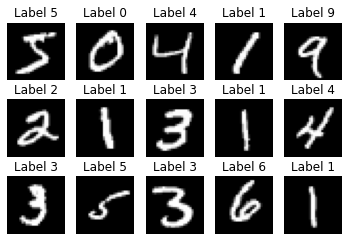

In [ ]:
plot_digits(mnist_X_train[:15],mnist_y_train[:15],(3,5))

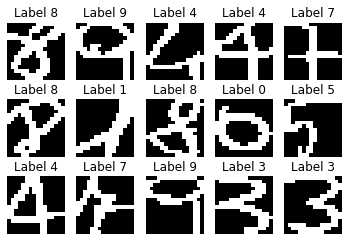

In [ ]:
plot_digits(semeion_X_train[:15],semeion_y_train[:15],(3,5))

### Data Exploration

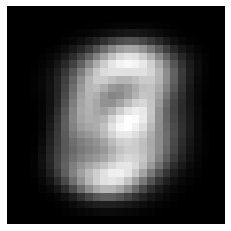

In [ ]:
plot_digits(np.mean(mnist_X_train, axis=0))

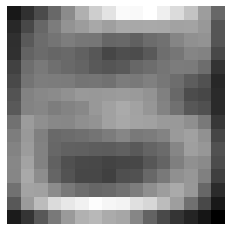

In [ ]:
plot_digits(tf.math.reduce_mean(semeion_X_train, axis=0))

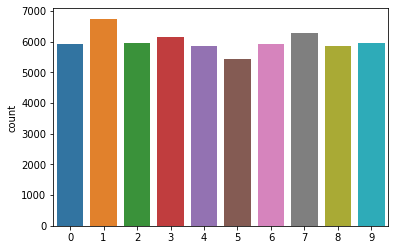

In [ ]:
sns.countplot(x=mnist_y_train)

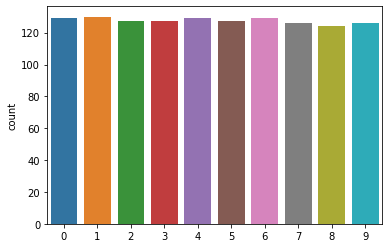

In [ ]:
sns.countplot(x=semeion_y_train)

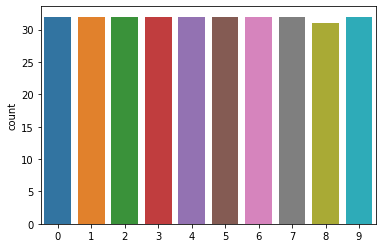

In [ ]:
sns.countplot(x=semeion_y_test)

### Data Preprocessing

#### Label Splitting

Only label 0 to label 4 are used during training.

In [ ]:
mnist_0_4 = np.nonzero(mnist_y_train < 5)[0]
mnist_5_9 = np.nonzero(mnist_y_train >= 5)[0]
semeion_0_4 = np.nonzero(semeion_y_train < 5)[0]
semeion_5_9 = np.nonzero(semeion_y_train >= 5)[0]

In [ ]:
mnist_0_4, mnist_5_9

(array([    1,     2,     3, ..., 59991, 59994, 59996]),
 array([    0,     4,    11, ..., 59997, 59998, 59999]))

In [ ]:
semeion_0_4, semeion_5_9

(array([   2,    3,    6,    8,   10,   13,   14,   16,   17,   18,   20,
          21,   26,   27,   29,   30,   31,   33,   34,   35,   38,   40,
          42,   45,   46,   47,   48,   50,   52,   54,   55,   56,   57,
          61,   64,   65,   67,   70,   71,   74,   75,   76,   77,   78,
          79,   80,   82,   84,   85,   87,   88,   90,   93,   94,   95,
          96,   97,  100,  102,  103,  106,  109,  110,  116,  117,  118,
         120,  121,  123,  124,  126,  127,  128,  130,  135,  136,  138,
         140,  141,  143,  144,  145,  147,  150,  152,  153,  154,  155,
         157,  158,  159,  163,  165,  168,  169,  170,  171,  172,  173,
         178,  179,  180,  184,  185,  191,  192,  199,  200,  201,  202,
         203,  206,  207,  209,  211,  214,  215,  216,  218,  219,  220,
         223,  224,  228,  231,  233,  235,  236,  239,  243,  245,  246,
         247,  249,  251,  252,  253,  254,  256,  259,  261,  262,  265,
         266,  267,  268,  272,  275, 

The same applies to the test set.

In [ ]:
mnist_0_4t = np.nonzero(mnist_y_test < 5)[0]
mnist_5_9t = np.nonzero(mnist_y_test >= 5)[0]
semeion_0_4t = np.nonzero(semeion_y_test < 5)[0]
semeion_5_9t = np.nonzero(semeion_y_test >= 5)[0]

In [ ]:
mnist_0_4t, mnist_5_9t

(array([   1,    2,    3, ..., 9995, 9996, 9997]),
 array([   0,    7,    8, ..., 9992, 9998, 9999]))

In [ ]:
semeion_0_4t, semeion_5_9t

(array([  0,   1,   2,   3,   6,   7,   9,  10,  13,  14,  19,  20,  21,
         22,  23,  24,  27,  29,  31,  37,  38,  39,  40,  41,  43,  46,
         48,  54,  55,  58,  59,  61,  62,  64,  65,  66,  67,  68,  69,
         72,  78,  82,  83,  84,  85,  87,  88,  89,  92,  93,  94,  98,
        101, 103, 104, 108, 110, 113, 115, 116, 117, 122, 124, 126, 127,
        129, 130, 131, 133, 134, 136, 137, 139, 140, 141, 143, 145, 149,
        150, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 166, 168,
        170, 172, 173, 174, 183, 184, 186, 187, 188, 192, 193, 196, 198,
        200, 202, 203, 204, 211, 212, 219, 222, 223, 225, 227, 231, 236,
        237, 238, 240, 244, 245, 246, 247, 248, 250, 253, 254, 255, 257,
        258, 259, 260, 262, 263, 264, 265, 269, 271, 273, 275, 276, 282,
        284, 285, 286, 287, 289, 290, 295, 300, 301, 302, 305, 306, 308,
        311, 312, 314, 317]),
 array([  4,   5,   8,  11,  12,  15,  16,  17,  18,  25,  26,  28,  30,
         32,  33,  34

#### Image Resize

Resize the images to $32\times 32$.

In [ ]:
mnist_X_train = mnist_X_train[:, :, :, np.newaxis]
mnist_X_train = tf.broadcast_to(mnist_X_train, mnist_X_train.shape[:-1] + (3,))
mnist_X_train = tf.image.resize(mnist_X_train, (32,32))

In [ ]:
mnist_X_train.shape

TensorShape([60000, 32, 32, 3])

In [ ]:
semeion_X_train = semeion_X_train[:, :, :, np.newaxis]
semeion_X_train = tf.broadcast_to(semeion_X_train, semeion_X_train.shape[:-1] + (3,))
semeion_X_train = tf.image.resize(semeion_X_train, (32,32))

In [ ]:
semeion_X_train.shape

TensorShape([1274, 32, 32, 3])

The same applies to the test set.

In [ ]:
mnist_X_test = mnist_X_test[:, :, :, np.newaxis]
mnist_X_test = tf.broadcast_to(mnist_X_test, mnist_X_test.shape[:-1] + (3,))
mnist_X_test = tf.image.resize(mnist_X_test, (32,32))

In [ ]:
mnist_X_test.shape

TensorShape([10000, 32, 32, 3])

In [ ]:
semeion_X_test = semeion_X_test[:, :, :, np.newaxis]
semeion_X_test = tf.broadcast_to(semeion_X_test, semeion_X_test.shape[:-1] + (3,))
semeion_X_test = tf.image.resize(semeion_X_test, (32,32))

In [ ]:
semeion_X_test.shape

TensorShape([319, 32, 32, 3])

#### Data Scaling

Check the bound of the data.

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
tf.math.reduce_min(semeion_X_train), tf.math.reduce_max(semeion_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Scale the MNIST data to [0, 1].

In [ ]:
mnist_X_train = mnist_X_train / 255.0

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

The same applies to the test set.

In [ ]:
mnist_X_test = mnist_X_test / 255.0

In [ ]:
tf.math.reduce_min(mnist_X_test), tf.math.reduce_max(mnist_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

#### Data Normalization (disabled)

Normalize the data.

In [ ]:
mnist_train_mean = np.mean(mnist_X_train,)
mnist_train_std  = np.std(mnist_X_train)
# Centering
mnist_X_train    = mnist_X_train - mnist_train_mean
mnist_X_test     = mnist_X_test - mnist_train_mean

# Standardization
# mnist_X_train    = mnist_X_train / mnist_train_std
# mnist_X_test     = mnist_X_test / mnist_train_std

In [ ]:
mnist_train_mean, mnist_train_std

(0.13085152, 0.28923184)

In [ ]:
semeion_train_mean = np.mean(semeion_X_train)
semeion_train_std  = np.std(semeion_X_train)
# Centering
semeion_X_train    = semeion_X_train - semeion_train_mean
semeion_X_test     = semeion_X_test - semeion_train_mean

# Standardization
# semeion_X_train    = semeion_X_train / semeion_train_std
# semeion_X_test     = semeion_X_test / semeion_train_std

In [ ]:
semeion_train_mean, semeion_train_std

(0.32774174, 0.40350488)

In [ ]:
# mnist_train_mean = 0.0
mnist_train_std  = 1.0
# semeion_train_mean = 0.0
semeion_train_std  = 1.0

## Model Components

### Feature Encoder Network

In [ ]:
def FeatureEncoder(name=None):
    '''
    Return a Feature Encoder.
    '''
    fe_input = keras.Input(shape=(32,32,3))
    x = keras.layers.Dropout(0.2)(fe_input)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    fe_out = keras.layers.Flatten()(x)
    if (name is None):
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name='FeatureExtractor')
    else:
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name=name)
    return fe

In [ ]:
fe_demo = FeatureEncoder()
fe_demo.summary()

Model: "FeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 64)     

### Classification Network

In [ ]:
def ClassificationNet(name=None):
    '''
    Return a Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    cl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(cl_input)
    cl_out = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name='ClassificationNetwork')
    else:
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name=name)
    return cl

In [ ]:
cl_demo = ClassificationNet()
cl_demo.summary()

Model: "ClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 645       
Total params: 17,157
Trainable params: 17,157
Non-trainable params: 0
_________________________________________________________________


### Source Domain Decoder and Discriminator

In [ ]:
def SourceTargetDecoder(name=None):
    dc_input = keras.Input(shape=[128])
    x = keras.layers.Reshape((1,1,128))(dc_input)
    # ConvTran,  2×2 , 512, stride 1, padding 0, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=512, kernel_size=2, strides=1,
                                     padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 256, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 128, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 64, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 3, stride 2, padding 1, Tanh
    dc_out = keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2,
                                          padding='same', activation="tanh")(x)
    if (name is None):
        dc = keras.Model(inputs=dc_input, outputs=dc_out, name='Decoder')
    else:
        dc = keras.Model(inputs=dc_input, outputs=dc_out, name=name)
    return dc

In [ ]:
st_decoder = SourceTargetDecoder()
st_decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 2, 2, 512)         262656    
_________________________________________________________________
batch_normalization_38 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
re_lu_20 (ReLU)              (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 4, 4, 256)         2097408   
_________________________________________________________________
batch_normalization_39 (Batc (None, 4, 4, 256)         1024

In [ ]:
def SourceDomainDiscriminator(name=None):
    '''
    Return a Source Domain Discriminator.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    sd_input = keras.Input((32,32,3))
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                            padding='same')(sd_input)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(4, strides=4)(x)
    x = keras.layers.Flatten()(x)
    sd_out_bin = keras.layers.Dense(1, activation='sigmoid')(x)
    sd_out_aux = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        sd = keras.Model(inputs=sd_input, outputs=(sd_out_bin, sd_out_aux),
                         name='SourceDomainDiscriminator')
    else:
        sd = keras.Model(inputs=sd_input, outputs=(sd_out_bin, sd_out_aux),
                         name=name)
    return sd

In [ ]:
sdd_demo = SourceDomainDiscriminator()
sdd_demo.summary()

Model: "SourceDomainDiscriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 64)   1792        input_21[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 32, 32, 64)   0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 32, 32, 64)   256         leaky_re_lu_18[0][0]             
__________________________________________________________________________

### Target Domain Decoder and Discriminator

In [ ]:
def TargetDomainDiscriminator(name=None):
    td_input = keras.Input((32,32,3))
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                        padding='same')(td_input)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(4, strides=4)(x)
    x = keras.layers.Flatten()(x)
    td_out = keras.layers.Dense(1, activation='sigmoid')(x)
    if (name is None):
        td = keras.Model(inputs=td_input, outputs=td_out, name='TargetDomainDiscriminator')
    else:
        td = keras.Model(inputs=td_input, outputs=td_out, name=name)
    return td

In [ ]:
tgt_demo = TargetDomainDiscriminator()
tgt_demo.summary()

Model: "TargetDomainDiscriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 1

## Compose the Model

### Wiring

Wiring up the components.

In [ ]:
def ProposedMethod(noise=0.0):
    # Input layer
    prop_input_src = keras.Input(shape=(32,32,3), name="SourceInput")
    prop_input_tgt = keras.Input(shape=(32,32,3), name="TargetInput")

    # Fed to the same feature extractor
    prop_fe = FeatureEncoder()
    prop_fe_src = prop_fe(prop_input_src)
    prop_fe_tgt = prop_fe(prop_input_tgt)
    prop_fe_combine = keras.layers.Concatenate(axis=0)([prop_fe_src,prop_fe_tgt])

    # Source representation flows to the classification network
    prop_out_cl = ClassificationNet()(prop_fe_src)

    # Source and target flow to the source domain discriminator
    prop_sd = SourceTargetDecoder('SourceDecoder')
    prop_sd_combine = prop_sd(prop_fe_combine)
    prop_sd_com2 = keras.layers.Concatenate(axis=0)([prop_sd_combine,
                   keras.layers.GaussianNoise(stddev=noise)(prop_input_src)])
    prop_sdd = SourceDomainDiscriminator()
    prop_sdd_combine = prop_sdd(prop_sd_com2)

    # Source and target flow to the target domain discriminator
    prop_td = SourceTargetDecoder('TargetDecoder')
    prop_td_combine = prop_td(prop_fe_combine)
    prop_td_com2 = keras.layers.Concatenate(axis=0)([prop_td_combine,
                   keras.layers.GaussianNoise(stddev=noise)(prop_input_tgt)])
    prop_tdd = TargetDomainDiscriminator()
    prop_tdd_combine = prop_tdd(prop_td_com2)

    # Final model
    mod_proposed = keras.Model(
        inputs=[prop_input_src, prop_input_tgt],
        outputs=[prop_out_cl,         # Categorical Classifier
                 prop_sdd_combine,    # Source Domain Discriminator Output
                 prop_tdd_combine,    # Target Domain Discriminator Output
                 prop_sd_combine,     # Source Generator Output
                 prop_td_combine,]    # Target Generator Output
    )
    return mod_proposed

In [ ]:
mod_proposed = ProposedMethod()
mod_proposed.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SourceInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
TargetInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
FeatureExtractor (Functional)   (None, 128)          312256      SourceInput[0][0]                
                                                                 TargetInput[0][0]                
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128)          0           FeatureExtractor[0][0]

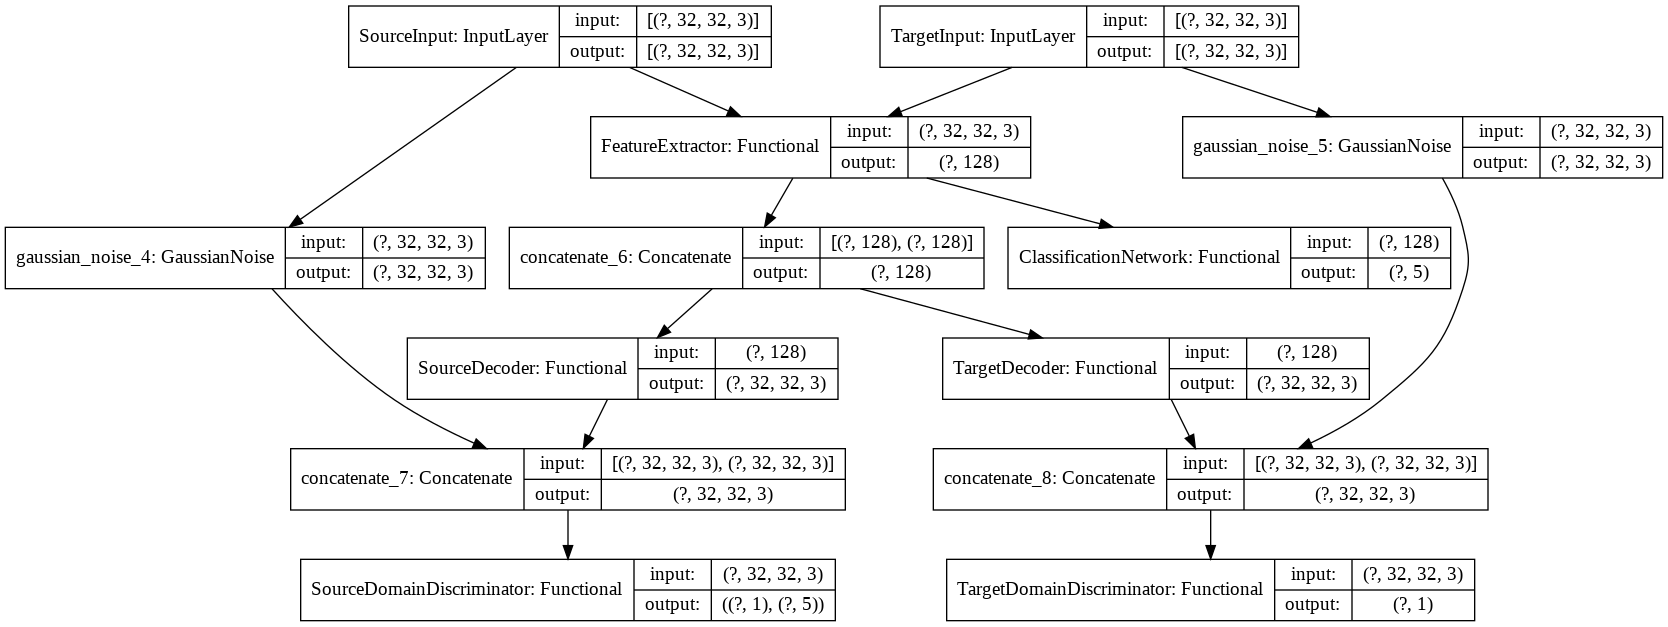

In [ ]:
keras.utils.plot_model(mod_proposed, os.path.join(runpath,'proposed_model.png'), show_shapes=True)

### Helper Functions

Sample a random batch from the dataset.

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return tf.gather(X, idx), tf.gather(y, idx)

Print the status bar during training and evaluation.

In [ ]:
def print_status_bar(iteration, total, loss=None):
    if (loss is not None):
        metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                             for m in loss])
    else:
        metrics = 'No loss available'
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

Well split the full output of the proposed model.

In [ ]:
def model_output(model, X_src_batch, X_tgt_batch):
    src_size = len(X_src_batch)
    tgt_size = len(X_tgt_batch)

    # Get discriminators
    comp_sdd = model.get_layer('SourceDomainDiscriminator')
    comp_tdd = model.get_layer('TargetDomainDiscriminator')

    # Feed-forward Network
    outputs = model((X_src_batch, X_tgt_batch))
    
    # Separate the outputs
    (out_cl, sd_combine, td_combine,
     gen_sd_combine, gen_td_combine) = outputs
    sd_com_tf, sd_com_cl = sd_combine
    sd_src_tf, sd_tgt_tf, sd_clean_tf = (sd_com_tf[:src_size],
                                         sd_com_tf[src_size:(src_size+tgt_size)],
                                         sd_com_tf[(src_size+tgt_size):],
                                         )
    sd_src_cl, sd_tgt_cl, sd_clean_cl = (sd_com_cl[:src_size],
                                         sd_com_cl[src_size:(src_size+tgt_size)],
                                         sd_com_cl[(src_size+tgt_size):],
                                         )
    td_src, td_tgt, td_clean = (td_combine[:src_size],
                                td_combine[src_size:(src_size+tgt_size)],
                                td_combine[(src_size+tgt_size):],
                                )
    gen_sd_src, _ = gen_sd_combine[:src_size], gen_sd_combine[src_size:]
    _, gen_td_tgt = gen_td_combine[:src_size], gen_td_combine[src_size:]

    return (out_cl,
            sd_src_tf, sd_src_cl, sd_tgt_tf,
            sd_tgt_cl, sd_clean_tf, sd_clean_cl,
            td_src, td_tgt, td_clean,
            gen_sd_src, gen_td_tgt)

Plot AUROC (area under the ROC) curve.

In [ ]:
def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

### Training Loop

Write the custom training loop. The training procedure is as follows:

1. Feed-forward using Eq. (1) and Eq. (2). Inside the `tf.GradientTape()` block, calculate all losses given by Eq. (3) to Eq. (12).
    1. Train the discriminators first. Feed the source images and target images to the network first. Before it reaches the discriminators, concatenate the source images and construct the pairs of training images.
    2. Train the rest of the network. Freeze the discriminators. Calculate the loss and apply the gradients to all the trainable parameters.
2. For each set of parameters, apply the gradients according to the loss function.

In all experiments, we use Adam optimizer with the learning rate ($\eta$) of 0.0001 and batch size ($N$) of 64. The hyper-parameter $\lambda_1$ and $\lambda_2$ are both set equal to 0.03. The parameters are chosen using validation performance from the source domain data. Details regarding the network architectures used for $F$, $C$, $G_s$, $G_t$, $D_s$ and $D_t$ are provided in supplementary material.

In [ ]:
def train_proposed_model(model, X_src, y_src, X_tgt, y_tgt, optimizers,
                         lambda1=0.03, lambda2=0.03, batch_size=64, n_epochs=50,
                         start_epoch=1, name=None):
    # Get the sample size, number of steps, source size, and target size
    # n_samples = (len(X_src) + len(X_tgt))
    # n_steps = n_samples // batch_size
    # src_size = (batch_size * len(X_src) // n_samples
    # tgt_size = (batch_size * len(X_tgt) // n_samples
    n_samples = max(len(X_src), len(X_tgt))
    n_steps = n_samples // int(batch_size / 2)
    src_size = int(batch_size / 2)
    tgt_size = int(batch_size / 2)

    # Define loss functions
    cat_loss = keras.losses.CategoricalCrossentropy()
    bin_loss = keras.losses.BinaryCrossentropy()
    l1_loss = keras.losses.MeanAbsoluteError()
    
    # Get each individual components
    comp_sdd = model.get_layer('SourceDomainDiscriminator')
    comp_tdd = model.get_layer('TargetDomainDiscriminator')
    comp_sg = model.get_layer('SourceDecoder')
    comp_tg = model.get_layer('TargetDecoder')
    comp_fe = model.get_layer('FeatureExtractor')
    comp_cn = model.get_layer('ClassificationNetwork')
    
    # Define loss metrics and the history tracker
    loss_name = ['loss_ds_cgan','loss_dt_gan', 'loss_ce', 'loss_gs_cgan',
                 'loss_gs_rs','loss_gt_gan', 'loss_gt_rt', 'loss_f_total']
    mean_loss = []
    for l in loss_name:
        mean_loss.append(keras.metrics.Mean(name=l))
    history = []
    
    for epoch in range(start_epoch, n_epochs + 1):
        print("Epoch {}/{}".format(epoch, n_epochs))
        for step in range(1, n_steps + 1):
            # Sample a batch from source and target data
            X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
            X_tgt_batch, y_tgt_batch = random_batch(X_tgt, y_tgt, tgt_size)
            
            # ########## Train the discriminator first ##########
            comp_sdd.trainable = True
            comp_tdd.trainable = True
            for l in comp_sdd.layers:
                l.trainable = True
            for l in comp_tdd.layers:
                l.trainable = True
            with tf.GradientTape(persistent=True) as tape:
                # Feed-forward Network
                gen_sd_src = comp_sg(comp_fe(X_src_batch))
                gen_sd_tgt = comp_sg(comp_fe(X_tgt_batch))
                gen_sd_com = tf.concat((gen_sd_src, gen_sd_tgt, X_src_batch), axis=0)
                gen_td_src = comp_tg(comp_fe(X_src_batch))
                gen_td_tgt = comp_tg(comp_fe(X_tgt_batch))
                gen_td_com = tf.concat((gen_td_src, gen_td_tgt, X_tgt_batch), axis=0)
                
                # Feed three sets of images to the discriminator
                sd_com_tf, sd_com_cl = comp_sdd(gen_sd_com, training=True)
                sd_true_tf = tf.constant([[0.]] * src_size +
                                         [[0.]] * tgt_size +
                                         [[1.]] * src_size
                                        )
                sd_src_cl = sd_com_cl[:src_size]

                td_com = comp_tdd(gen_td_com, training=True)
                td_true = tf.constant([[0.]] * src_size +
                                      [[0.]] * tgt_size +
                                      [[1.]] * tgt_size
                                     )
                
                # Calculate the losses
                loss_ds_cgan = (bin_loss(sd_true_tf, sd_com_tf) +
                                cat_loss(tf.one_hot(y_src_batch,5), keras.activations.softmax(sd_src_cl)))
                loss_dt_gan = bin_loss(td_true, td_com)
                
            # Apply the gradients
            gradient_sdd = tape.gradient(loss_ds_cgan,
                comp_sdd.trainable_variables)
            optimizers[0].apply_gradients(zip(gradient_sdd,
                comp_sdd.trainable_variables))
            gradient_tdd = tape.gradient(loss_dt_gan,
                comp_tdd.trainable_variables)
            optimizers[1].apply_gradients(zip(gradient_tdd,
                comp_tdd.trainable_variables))
            mean_loss[0](loss_ds_cgan)
            mean_loss[1](loss_dt_gan)
            
            # Delete the tape
            del(tape)
            
            # ########## Train the rest of the network ##########
            comp_sdd.trainable = False
            comp_tdd.trainable = False
            for l in comp_sdd.layers:
                l.trainable = False
            for l in comp_tdd.layers:
                l.trainable = False
            with tf.GradientTape(persistent=True) as tape:
                # Feed-forward Network
                outputs = model((X_src_batch, X_tgt_batch), training=True)
                
                # Separate the outputs
                (out_cl, sd_combine, td_combine,
                 gen_sd_combine, gen_td_combine) = outputs
                sd_com_tf, sd_com_cl = sd_combine
                gen_sd_src, _ = gen_sd_combine[:src_size], gen_sd_combine[src_size:]
                _, gen_td_tgt = gen_td_combine[:src_size], gen_td_combine[src_size:]
                
                # Calculate the losses
                loss_ce = cat_loss(tf.one_hot(y_src_batch,5), keras.activations.softmax(out_cl))
                loss_gs_cgan = bin_loss(tf.constant([[1.]] * (src_size+tgt_size)), sd_com_tf[:(src_size+tgt_size)])
                loss_gs_rs = l1_loss(X_src_batch, gen_sd_src)
                loss_gt_gan = bin_loss(tf.constant([[1.]] * (src_size+tgt_size)), td_combine[:(src_size+tgt_size)])
                loss_gt_rt = l1_loss(X_tgt_batch, gen_td_tgt)
                loss_f_total = loss_ce + lambda1 * loss_gs_cgan + lambda2 * loss_gt_gan
            
            # Apply the gradients
            gradient_sg = tape.gradient(loss_gs_cgan,
                comp_sg.trainable_variables)
            optimizers[2].apply_gradients(zip(gradient_sg,
                comp_sg.trainable_variables))
            gradient_tg = tape.gradient(loss_gt_gan,
                comp_tg.trainable_variables)
            optimizers[3].apply_gradients(zip(gradient_tg,
                comp_tg.trainable_variables))
            gradient_fe = tape.gradient(loss_f_total,
                comp_fe.trainable_variables)
            optimizers[4].apply_gradients(zip(gradient_fe,
                comp_fe.trainable_variables))
            gradient_cn = tape.gradient(loss_ce,
                comp_cn.trainable_variables)
            optimizers[5].apply_gradients(zip(gradient_cn,
                comp_cn.trainable_variables))
            gradient_sg = tape.gradient(loss_gs_rs,
                comp_sg.trainable_variables)
            optimizers[6].apply_gradients(zip(gradient_sg,
                comp_sg.trainable_variables))
            gradient_tg = tape.gradient(loss_gt_rt,
                comp_tg.trainable_variables)
            optimizers[7].apply_gradients(zip(gradient_tg,
                comp_tg.trainable_variables))
            mean_loss[2](loss_ce)
            mean_loss[3](loss_gs_cgan)
            mean_loss[4](loss_gs_rs)
            mean_loss[5](loss_gt_gan)
            mean_loss[6](loss_gt_rt)
            mean_loss[7](loss_f_total)
            
            # Print Status Bar
            print_status_bar(step * (batch_size // 2), n_samples, mean_loss)

            # Save the history
            history.append([m.result() for m in mean_loss])
            
            # Delete the tape
            del(tape)

        # Refresh the status bar
        print_status_bar(n_samples, n_samples, mean_loss)
        
        # Save the model at this epoch
        model.save(name + '_epoch_' + str(epoch) + time.strftime("_%Y_%m_%d-%H_%M_%S"))
        
        # Reset the metrics
        for loss in mean_loss:
            loss.reset_states()

    return np.array(history)

### Novelty Detector

The paper mentioned that the novel samples are detected based on "the addition" of maximum softmax probability, generator loss on the target domain, and target domain discriminator score.

1. Maximum softmax probability comes from the classification network. The smaller the value, the more uncertain the model is. For novel samples, the model should be much more uncertain than the known samples. They would have smaller softmax probability scores. (MINIMIZATION)
2. Generator loss comes from the target domain decoder. The larger the value, the larger difference the reconstructed image has compared to the original image. For novel samples, this value should be much larger. (MAXIMIZATION)
3. Discriminator score comes from the target domain discriminator. For novel samples, they are more likely to be classified as fake images. So, they would have much smaller discriminator scores. (MINIMIZATION)

In [ ]:
def novelty_detector(model, X, c_softmax=1.0, c_gloss=1.0, c_dscore=1.0):
    '''
    A novelty detector based on proposed method. Output a score based on maximum softmax probability,
    generator loss, and discriminator score.
    '''
    batch_size = 64
    n_batch = len(X) // batch_size
    softmax_score = np.array([]).reshape(0)
    generator_score = np.array([]).reshape(0)
    discriminator_score = np.array([]).reshape(0)

    print('Novelty Detector - Computing Outputs')
    
    for i in range(n_batch):
        s = i * batch_size
        e = (i+1) * batch_size
        outputs = mod_proposed((X[s:e], X[s:e]))
        (out_cl, sd_combine, td_combine,
         gen_sd_combine, gen_td_combine) = outputs
        td_tgt = td_combine[:(e-s)]
        _, gen_td_tgt = gen_td_combine[:(e-s)], gen_td_combine[(e-s):]
        
        softmax_score = np.concatenate((softmax_score,
            tf.math.reduce_max(tf.nn.softmax(out_cl),
                               axis=1)))
        generator_score = np.concatenate((generator_score,
            tf.math.reduce_mean(tf.math.abs(X[s:e] - gen_td_tgt), axis=(1,2,3))))
        discriminator_score = np.concatenate((discriminator_score,
            tf.squeeze(td_tgt)))
        
        print_status_bar(i * batch_size, len(X))
    
    s = n_batch * batch_size
    e = len(X)
    outputs = mod_proposed((X[s:e], X[s:e]))
    (out_cl, sd_combine, td_combine,
        gen_sd_combine, gen_td_combine) = outputs
    td_tgt = td_combine[:(e-s)]
    _, gen_td_tgt = gen_td_combine[:(e-s)], gen_td_combine[(e-s):]
    
    softmax_score = np.concatenate((softmax_score,
        tf.math.reduce_max(tf.nn.softmax(out_cl),
                            axis=1)))
    generator_score = np.concatenate((generator_score,
        tf.math.reduce_mean(tf.math.abs(X[s:e] - gen_td_tgt), axis=(1,2,3))))
    discriminator_score = np.concatenate((discriminator_score,
        tf.squeeze(td_tgt)))
    
    print_status_bar(len(X), len(X))
    
    return (generator_score * c_gloss - softmax_score * c_softmax - discriminator_score * c_dscore,
            softmax_score, generator_score, discriminator_score)

## Test & Evaluation

### Training

Create a new model or load an existing model.

In [ ]:
mod_proposed = ProposedMethod(noise=0.05)
# mod_proposed = tf.keras.models.load_model(os.path.join(filepath,'mnist_usps_epoch_20_2020_12_03-04_09_37'))

Train the model for 10 epochs.

In [ ]:
optimizers = []
for i in range(8):
    optimizers.append(keras.optimizers.Adam(learning_rate=0.0001))

history = train_proposed_model(mod_proposed, tf.gather(mnist_X_train, mnist_0_4),
                               tf.gather(mnist_y_train, mnist_0_4),
                               tf.gather(semeion_X_train, semeion_0_4),
                               tf.gather(semeion_y_train, semeion_0_4),
                               optimizers, batch_size=64, n_epochs=10,
                               name=os.path.join(runpath, 'mnist_semeion'))

Epoch 1/10
30596/30596 - loss_ds_cgan: 1.4928 - loss_dt_gan: 0.0011 - loss_ce: 0.7516 - loss_gs_cgan: 0.0571 - loss_gs_rs: 0.1440 - loss_gt_gan: 0.0629 - loss_gt_rt: 0.2390 - loss_f_total: 0.7552
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_09-03_42/mnist_semeion_epoch_1_2020_12_09-03_46_16/assets
Epoch 2/10
30596/30596 - loss_ds_cgan: 1.3212 - loss_dt_gan: 0.0000 - loss_ce: 0.6616 - loss_gs_cgan: 0.0769 - loss_gs_rs: 0.0841 - loss_gt_gan: 0.1743 - loss_gt_rt: 0.2380 - loss_f_total: 0.6692
INFO:tensorflow:Assets written to: /content/drive/MyDrive/COURSES/EECS_545/Final_Project/Code/run_2020_12_09-03_42/mnist_semeion_epoch_2_2020_12_09-03_49_47/assets
Epoch 3/10
30596/30596 - loss_ds_cgan: 1.0024 

In [ ]:
np.save(os.path.join(runpath, 'mnist_semeion_history'), history)
history.shape

(9560, 8)

Visualize the training history.

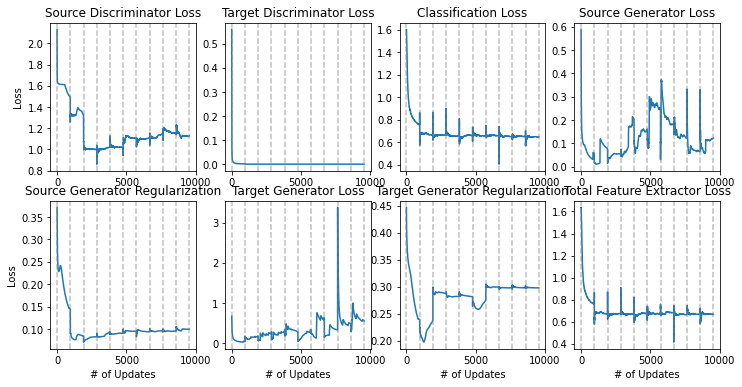

In [ ]:
semantic_labels = ('Source Discriminator Loss','Target Discriminator Loss',
                   'Classification Loss', 'Source Generator Loss',
                   'Source Generator Regularization','Target Generator Loss',
                   'Target Generator Regularization', 'Total Feature Extractor Loss')
epoch_index = np.linspace(0,len(history),11)
fig, ax = plt.subplots(2,4,figsize=(12,6))
for i in range(8):
    ax.flatten()[i].plot(range(len(history)), history[:,i])
    ax.flatten()[i].set_title(semantic_labels[i])
    if (i>3):
        ax.flatten()[i].set_xlabel('# of Updates')
    if (i%4==0):
        ax.flatten()[i].set_ylabel('Loss')
    for j in range(len(epoch_index)):
        ax.flatten()[i].axvline(epoch_index[j], c='gray', ls='--', alpha=0.5)

fig.savefig(os.path.join(runpath, 'mnist_semeion_loss.png'), dpi=300)
fig.show()

### Diagnostic Stats on Training Set

**Load a specific model by executing the following block**

In [ ]:
# mod_proposed = tf.keras.models.load_model(os.path.join(filepath,'mnist_semeion_epoch_20_2020_12_03-04_09_37'))

Evaluate the performance with the training set and known classes (0-4).

In [ ]:
index = np.random.randint(0, min(len(mnist_0_4), len(semeion_0_4)), 10)
X_src, X_tgt = (tf.gather(mnist_X_train, mnist_0_4[index]), 
                tf.gather(semeion_X_train, semeion_0_4[index]))
y_src, y_tgt = (tf.gather(mnist_y_train, mnist_0_4[index]),
                tf.gather(semeion_y_train, semeion_0_4[index]))
(out_cl, sd_src_tf, sd_src_cl, sd_tgt_tf, sd_tgt_cl,
 sd_clean_tf, sd_clean_cl, td_src, td_tgt, td_clean,
 gen_sd_src, gen_td_tgt) = model_output(mod_proposed, X_src, X_tgt)

In [ ]:
tf.nn.softmax(out_cl), tf.math.argmax(out_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [9.9997103e-01, 1.3162903e-05, 1.4374327e-05, 7.5393416e-07,
         7.5393416e-07],
        [2.3039542e-08, 1.0000000e+00, 2.3039542e-08, 2.3039542e-08,
         2.3039542e-08],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [9.8985811e-07, 8.9916211e-06, 9.9998808e-01, 9.8985811e-07,
         9.8985811e-07],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [9.8813591e-10, 1.0000000e+00, 9.8813591e-10, 9.8813591e-10,
         9.8813591e-10]], dtype=flo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

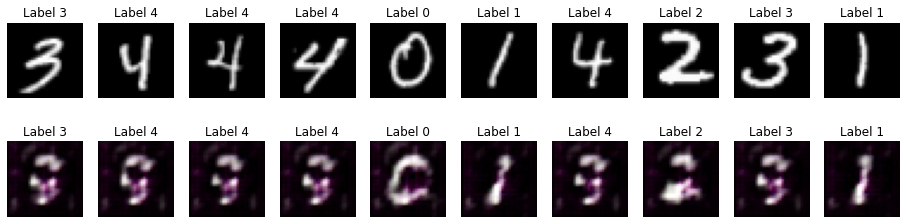

In [ ]:
fig, ax = plt.subplots(2,10,figsize=(16,4))
plot_color_digits(
    tf.concat((X_src, gen_sd_src),axis=0),
    np.concatenate((y_src, y_src),axis=0),
    grid=(2,10), ax=ax, mean=mnist_train_mean,
    std=mnist_train_std
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

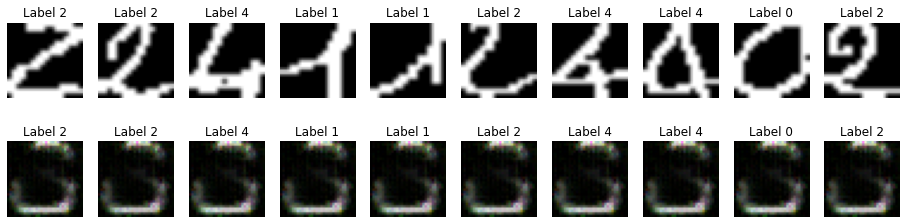

In [ ]:
fig, ax = plt.subplots(2,10,figsize=(16,4))
plot_color_digits(
    tf.concat((X_tgt, gen_td_tgt),axis=0),
    np.concatenate((y_tgt, y_tgt),axis=0),
    grid=(2,10), ax=ax, mean=semeion_train_mean,
    std=semeion_train_std
)

In [ ]:
sd_src_tf, tf.nn.softmax(sd_src_cl), tf.math.argmax(sd_src_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.1585689e-09],
        [4.7923693e-10],
        [2.9566347e-10],
        [4.2989909e-10],
        [5.8280092e-09],
        [3.6633261e-09],
        [8.2160012e-10],
        [8.2632496e-08],
        [4.7659526e-10],
        [3.7091390e-09]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[2.00000003e-01, 2.00000003e-01, 2.00000003e-01, 2.00000003e-01,
         2.00000003e-01],
        [2.00000003e-01, 2.00000003e-01, 2.00000003e-01, 2.00000003e-01,
         2.00000003e-01],
        [2.00000003e-01, 2.00000003e-01, 2.00000003e-01, 2.00000003e-01,
         2.00000003e-01],
        [2.00000003e-01, 2.00000003e-01, 2.00000003e-01, 2.00000003e-01,
         2.00000003e-01],
        [9.99985337e-01, 3.65656228e-06, 3.65656228e-06, 3.65656228e-06,
         3.65656228e-06],
        [2.00000003e-01, 2.00000003e-01, 2.00000003e-01, 2.00000003e-01,
         2.00000003e-01],
        [1.08941875e-01, 1.08941875e-0

In [ ]:
sd_tgt_tf, tf.nn.softmax(sd_tgt_cl), tf.math.argmax(sd_tgt_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[2.2727547e-09],
        [2.9985189e-10],
        [1.5280913e-10],
        [5.3485993e-10],
        [9.0225649e-10],
        [2.1870702e-10],
        [8.9510871e-10],
        [1.6905594e-10],
        [3.2316638e-10],
        [1.1467957e-09]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.18684465, 0.18684465, 0.18684465, 0.2526214 , 0.18684465],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2983804 , 0.17540489, 0.17540489, 0.17540489, 0.17540489],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
  

In [ ]:
sd_clean_tf, tf.nn.softmax(sd_clean_cl), tf.math.argmax(sd_clean_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.99984396],
        [0.99997747],
        [0.9991285 ],
        [0.99999547],
        [0.99999595],
        [0.99988914],
        [0.99998987],
        [0.9999994 ],
        [0.9999733 ],
        [0.9988716 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[6.0278565e-02, 2.7542053e-02, 2.7542053e-02, 8.5709524e-01,
         2.7542053e-02],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [9.8284525e-01, 4.2886743e-03, 4.2886743e-03, 4.2886743e-03,
         4.2886743e-03],
        [9.9999952e-01, 1.0224067e-07, 1.0224067e-07, 1.0224067e-07,
         1.0224067e-07],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
    

In [ ]:
td_src, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.1365205e-08],
        [2.1435522e-08],
        [6.8942390e-09],
        [1.7148235e-08],
        [1.1490405e-08],
        [1.1336346e-08],
        [1.3880178e-08],
        [3.6643812e-09],
        [1.6905224e-08],
        [1.6696482e-08]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 4, 1, 1, 2, 4, 4, 0, 2])>)

In [ ]:
td_tgt, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[4.9463273e-09],
        [1.8452333e-08],
        [1.2886787e-09],
        [4.2574180e-09],
        [6.6877108e-09],
        [4.4308921e-09],
        [4.6210316e-09],
        [9.5653157e-09],
        [2.8427023e-09],
        [1.1276008e-08]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 4, 1, 1, 2, 4, 4, 0, 2])>)

In [ ]:
td_clean, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 2, 4, 1, 1, 2, 4, 4, 0, 2])>)

Evaluate the performance with the training set and novel classes (5-9).

In [ ]:
X_src, X_tgt = (tf.gather(mnist_X_train, mnist_5_9)[:10], 
                tf.gather(semeion_X_train, semeion_5_9)[:10])
y_src, y_tgt = (tf.gather(mnist_y_train, mnist_5_9)[:10],
                tf.gather(semeion_y_train, semeion_5_9)[:10])
(out_cl, sd_src_tf, sd_src_cl, sd_tgt_tf, sd_tgt_cl,
 sd_clean_tf, sd_clean_cl, td_src, td_tgt, td_clean,
 gen_sd_src, gen_td_tgt) = model_output(mod_proposed, X_src, X_tgt)

In [ ]:
tf.nn.softmax(out_cl), tf.math.argmax(out_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.03402824, 0.9353257 , 0.01021538, 0.01021538, 0.01021538],
        [0.62734383, 0.09316404, 0.09316404, 0.09316404, 0.09316404],
        [0.4276498 , 0.12950411, 0.18383783, 0.12950411, 0.12950411],
        [0.05053537, 0.79785854, 0.05053537, 0.05053537, 0.05053537],
        [0.5545779 , 0.11135554, 0.11135554, 0.11135554, 0.11135554],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.10569392, 0.32453817, 0.35838002, 0.10569392, 0.10569392]],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 0, 1, 0, 0, 0, 2])>,
 <tf.Tensor: shape=(10,), dtype=uint8, numpy=array([5, 9, 5, 6, 7, 8, 6, 9, 9, 7], dtype=uint8)>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

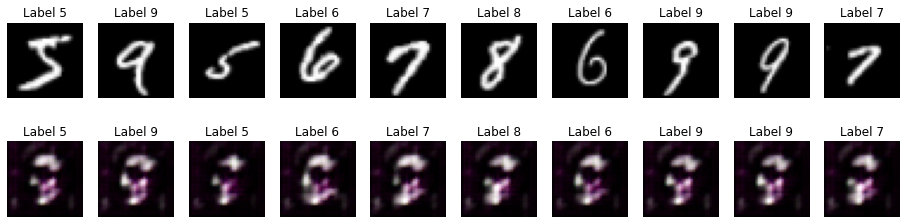

In [ ]:
fig, ax = plt.subplots(2,10,figsize=(16,4))
plot_color_digits(
    tf.concat((X_src, gen_sd_src),axis=0),
    np.concatenate((y_src, y_src),axis=0),
    grid=(2,10), ax=ax, mean=mnist_train_mean,
    std=mnist_train_std
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

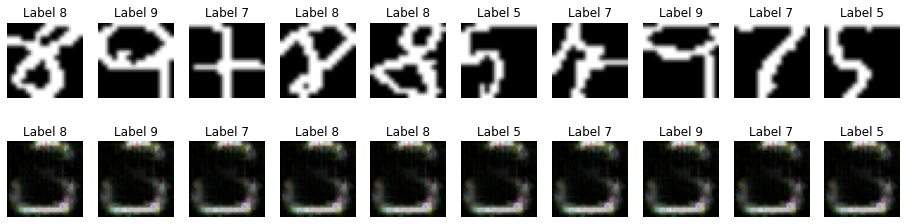

In [ ]:
fig, ax = plt.subplots(2,10,figsize=(16,4))
plot_color_digits(
    tf.concat((X_tgt, gen_td_tgt),axis=0),
    np.concatenate((y_tgt, y_tgt),axis=0),
    grid=(2,10), ax=ax, mean=semeion_train_mean,
    std=semeion_train_std
)

In [ ]:
sd_src_tf, tf.nn.softmax(sd_src_cl), tf.math.argmax(sd_src_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[9.6504327e-10],
        [4.3186993e-10],
        [6.1935002e-10],
        [4.6149248e-10],
        [2.8655156e-10],
        [7.6674500e-10],
        [1.9400924e-10],
        [4.0393602e-10],
        [4.7998244e-10],
        [9.4609609e-10]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.34855705, 0.16286072, 0.16286072, 0.16286072, 0.16286072],
        [0.96839404, 0.00790148, 0.00790148, 0.00790148, 0.00790148],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.8603977 , 0.03490056, 0.03490056, 0.03490056, 0.03490056],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
  

In [ ]:
sd_tgt_tf, tf.nn.softmax(sd_tgt_cl), tf.math.argmax(sd_tgt_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[6.6827094e-10],
        [1.0987431e-09],
        [9.8706976e-10],
        [8.2274482e-10],
        [5.8026722e-10],
        [5.3760202e-10],
        [5.0851612e-09],
        [2.7011143e-10],
        [1.8985873e-10],
        [9.9907072e-10]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.13595496, 0.13595496, 0.13595496, 0.4561801 , 0.13595496],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.19474171, 0.19474171, 0.19474171, 0.22103314, 0.19474171],
        [0.17570117, 0.17570117, 0.17570117, 0.29719537, 0.17570117],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
  

In [ ]:
sd_clean_tf, tf.nn.softmax(sd_clean_cl), tf.math.argmax(sd_clean_cl,axis=1), y_src

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.99999666],
        [0.9999603 ],
        [0.9999809 ],
        [0.9999987 ],
        [0.99999464],
        [0.9999405 ],
        [0.9989567 ],
        [0.999824  ],
        [0.999424  ],
        [0.9999436 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[3.4035650e-01, 1.1995559e-01, 1.1995559e-01, 2.9977673e-01,
         1.1995559e-01],
        [6.0188103e-01, 9.9529728e-02, 9.9529728e-02, 9.9529728e-02,
         9.9529728e-02],
        [9.8088205e-01, 4.7794678e-03, 4.7794678e-03, 4.7794678e-03,
         4.7794678e-03],
        [9.9828064e-01, 4.2982478e-04, 4.2982478e-04, 4.2982478e-04,
         4.2982478e-04],
        [9.0472943e-01, 2.3817629e-02, 2.3817629e-02, 2.3817629e-02,
         2.3817629e-02],
        [8.0190080e-01, 4.9524814e-02, 4.9524814e-02, 4.9524814e-02,
         4.9524814e-02],
        [9.6924210e-01, 6.0441531e-03, 6.0441531e-03, 1.2625516e-02,
         6.0441531e-03],
    

In [ ]:
td_src, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[7.43166417e-09],
        [2.49868268e-08],
        [1.36827150e-09],
        [1.20565025e-08],
        [1.65603264e-08],
        [8.15419732e-09],
        [5.43973622e-09],
        [1.35108351e-08],
        [1.02382929e-08],
        [9.92728744e-09]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 9, 7, 8, 8, 5, 7, 9, 7, 5])>)

In [ ]:
td_tgt, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[3.4152401e-09],
        [4.6423656e-09],
        [2.2115744e-08],
        [6.9424959e-09],
        [9.4788657e-09],
        [1.5572217e-08],
        [1.0412065e-08],
        [6.8431980e-09],
        [1.4954532e-08],
        [9.8988320e-09]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 9, 7, 8, 8, 5, 7, 9, 7, 5])>)

In [ ]:
td_clean, y_tgt

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.99999976],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 9, 7, 8, 8, 5, 7, 9, 7, 5])>)

### Novelty Detector on Target Training Set

In [ ]:
X_origin = tf.gather(semeion_X_train, semeion_0_4)
X_novel = tf.gather(semeion_X_train, semeion_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score, sm_score, g_score, d_score = novelty_detector(mod_proposed, X_tgt)

Novelty Detector - Computing Outputs
1274/1274 - No loss available


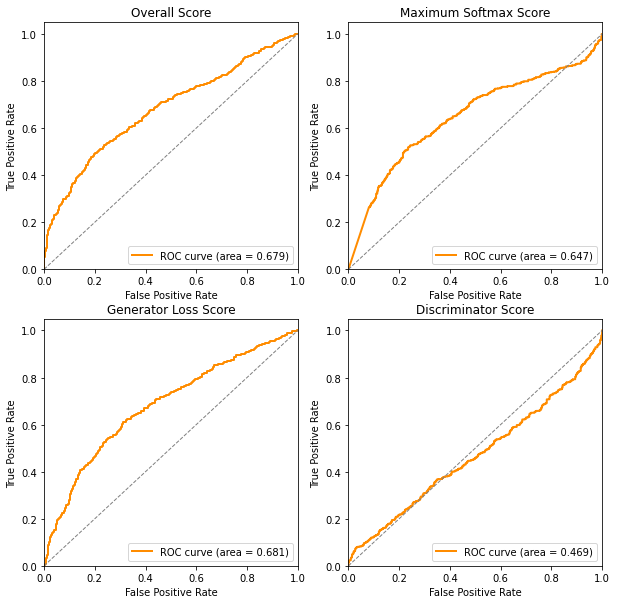

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

fpr, tpr, _ = roc_curve(y_tgt, y_score)
plot_auc_curve(fpr, tpr, ax[0,0])
ax[0,0].set_title('Overall Score')
fpr, tpr, _ = roc_curve(y_tgt, -sm_score)
plot_auc_curve(fpr, tpr, ax[0,1])
ax[0,1].set_title('Maximum Softmax Score')
fpr, tpr, _ = roc_curve(y_tgt, g_score)
plot_auc_curve(fpr, tpr, ax[1,0])
ax[1,0].set_title('Generator Loss Score')
fpr, tpr, _ = roc_curve(y_tgt, -d_score)
plot_auc_curve(fpr, tpr, ax[1,1])
ax[1,1].set_title('Discriminator Score')

fig.savefig(os.path.join(runpath, 'mnist_semeion_eval_train.png'), dpi=300)
fig.show()

### Novelty Detector on Target Test Set

In [ ]:
X_origin = tf.gather(semeion_X_test, semeion_0_4t)
X_novel = tf.gather(semeion_X_test, semeion_5_9t)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score, sm_score, g_score, d_score = novelty_detector(mod_proposed, X_tgt)

Novelty Detector - Computing Outputs
319/319 - No loss available


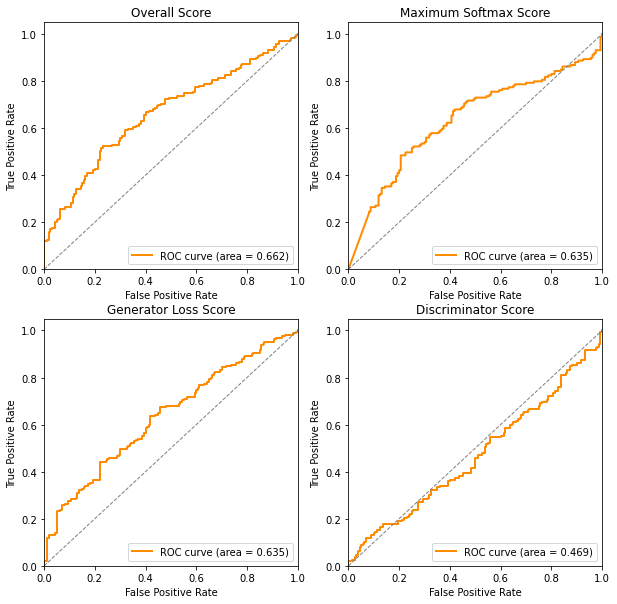

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

fpr, tpr, _ = roc_curve(y_tgt, y_score)
plot_auc_curve(fpr, tpr, ax[0,0])
ax[0,0].set_title('Overall Score')
fpr, tpr, _ = roc_curve(y_tgt, -sm_score)
plot_auc_curve(fpr, tpr, ax[0,1])
ax[0,1].set_title('Maximum Softmax Score')
fpr, tpr, _ = roc_curve(y_tgt, g_score)
plot_auc_curve(fpr, tpr, ax[1,0])
ax[1,0].set_title('Generator Loss Score')
fpr, tpr, _ = roc_curve(y_tgt, -d_score)
plot_auc_curve(fpr, tpr, ax[1,1])
ax[1,1].set_title('Discriminator Score')

fig.savefig(os.path.join(runpath, 'mnist_semeion_eval_test.png'), dpi=300)
fig.show()